In [2]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
IMAGE_PATH = 'Youtube Thumbnails/' # replace with your path


#image classification - VGG16
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image

#image classification - Xception
from tensorflow.keras.applications import Xception



#turn off warnings
import warnings
warnings.filterwarnings('ignore')




2023-03-26 09:53:45.622892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Images to array

Sample of images in data:
[[[0.         0.00784314 0.        ]
  [0.         0.00784314 0.        ]
  [0.         0.00784314 0.        ]
  ...
  [0.04313726 0.         0.00392157]
  [0.03529412 0.         0.01568628]
  [0.01960784 0.         0.02352941]]

 [[0.         0.00784314 0.        ]
  [0.         0.00784314 0.        ]
  [0.         0.00784314 0.        ]
  ...
  [0.         0.00784314 0.00392157]
  [0.00392157 0.00784314 0.01568628]
  [0.00392157 0.00784314 0.01568628]]

 [[0.         0.00784314 0.        ]
  [0.         0.00784314 0.        ]
  [0.         0.00784314 0.        ]
  ...
  [0.         0.02745098 0.01176471]
  [0.         0.02745098 0.01568628]
  [0.         0.02352941 0.01568628]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.      

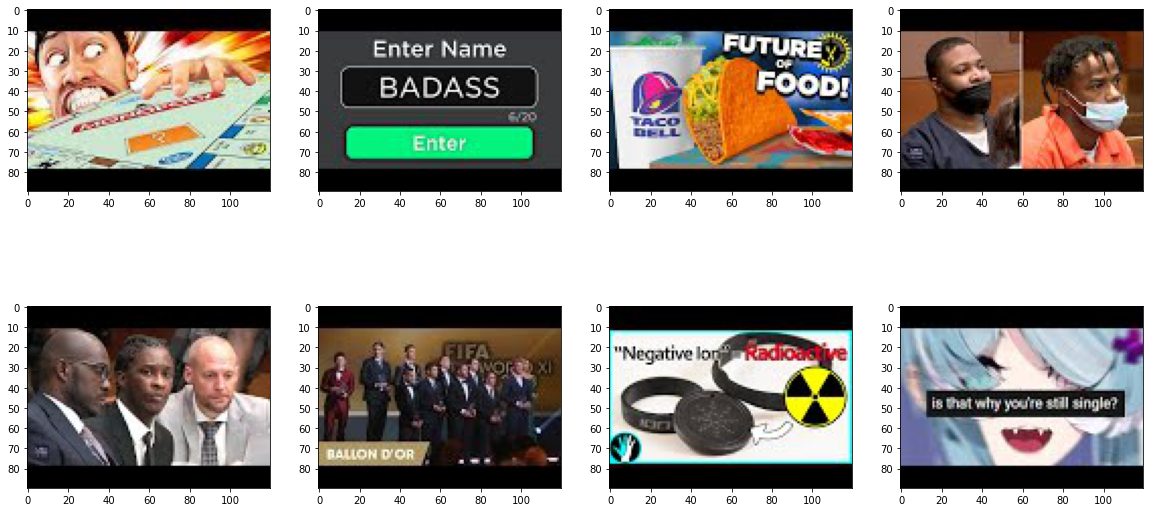

In [5]:
# read image
indx=0
images = []

print('Sample of images in data:')
for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    img = load_img(
    IMAGE_PATH + img)
    images.append(img)

print(img_to_array(images[0])/255)
    
nrows, ncols = 2,4 #print first 8 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
for i in range(nrows):
    for j in range(ncols):
        indx = i*ncols+j
        axs[i,j].imshow(images[indx])

In [99]:
def preprocess_data(IMAGE_PATH):
    """ Generate lists of images and video ids
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images  (np.ndarray): Images of shape (N, 120, 90, 3)
    """
    images = []
    video_ids = []

    # create lists of images `images_mini` 
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        
        # read video ID from path
        video_id = img.split('/')[0]
        video_id = video_id.split('.')[0]
        
        # read image
        img = load_img(
            IMAGE_PATH + img
        )
        
        # transform image to array
        img = img_to_array(img)

        #pre process
        img = img / 255
        
        # append to images
        images.append(img)
        video_ids.append(video_id)

    # stack images and trasnform to array
    images = np.stack(images)
    
    #flatten image pixel array and store in pd df with video ids
    images_flat = images.reshape(images.shape[0],images.shape[1] * images.shape[2] * images.shape[3])
    images_flat = pd.DataFrame(images_flat,columns=[("pixel_"+str(i)) for i in range(images_flat.shape[1])])
    images_ids = pd.DataFrame(video_ids,columns=["id"])
    images_df = pd.concat([images_ids,images_flat],axis=1)
    
    return images_df

In [97]:
images_df = preprocess_data(IMAGE_PATH)

In [98]:
images_df.head()

,id,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_32390,pixel_32391,pixel_32392,pixel_32393,pixel_32394,pixel_32395,pixel_32396,pixel_32397,pixel_32398,pixel_32399
0,MvuqM_9h6QY,0.000000,0.007843,0.000000,0.000000,0.007843,0.000000,0.000000,0.007843,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,hDk1ne5TCHM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,LbuoZYZLipc,0.000000,0.003922,0.019608,0.000000,0.003922,0.019608,0.000000,0.003922,0.019608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,hTqOeMob6uM,0.011765,0.000000,0.000000,0.011765,0.000000,0.000000,0.011765,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,RMxuWWN223o,0.000000,0.000000,0.007843,0.000000,0.000000,0.007843,0.000000,0.000000,0.007843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Transfer learning - image classification VGG16.


In [131]:
model = VGG16(weights='imagenet')


  5758976/553467096 [..............................] - ETA: 37:21

KeyboardInterrupt: 

In [100]:
def preprocess_data_vgg16(IMAGE_PATH):
    """ Generate lists of images and video ids
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images  (np.ndarray): Images of shape (N, 120, 90, 3)
    """
    images = []
    video_ids = []

    # create lists of images `images_mini` 
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        
        # read video ID from path
        video_id = img.split('/')[0]
        video_id = video_id.split('.')[0]
        
        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(224, 224)
        )
        
        # transform image to array
        img = img_to_array(img)

        #pre process
        img = preprocess_input(img)
        
        # append to images
        images.append(img)
        video_ids.append(video_id)

    # stack images and trasnform to array
    images = np.stack(images)
    
    return images, video_ids

In [101]:
# generate images based on preprocess_data_part1() function
images_vgg16 = preprocess_data_vgg16(IMAGE_PATH)

In [107]:
preds = model.predict(images_vgg16[0])

NameError: name 'model' is not defined

In [106]:
labels = decode_predictions(preds, top=3)
for label in labels[0]:
    #print(label[1], label[2])
    print(label)

NameError: name 'preds' is not defined

In [105]:
label_dict = {}
for idx, img_label in enumerate(labels):
    label_dict[images[1][idx]] = img_label[0][1],img_label[1][1],img_label[2][1], 

NameError: name 'labels' is not defined

In [13]:
len(label_dict.keys())

1189

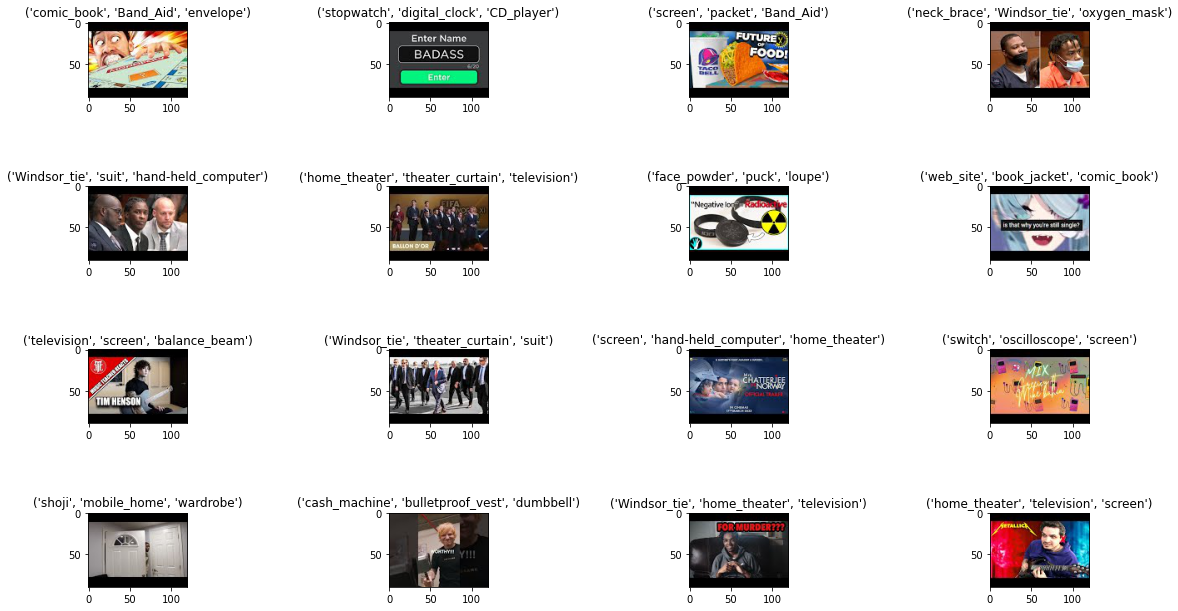

In [134]:
nrows, ncols = 4,4 #print first 16 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,8))
for i in range(nrows):
    for j in range(ncols):
        indx = i*ncols+j
        axs[i,j].imshow(images[0][indx])
        video_id = images[1][indx]
        axs[i,j].set(title=label_dict[video_id] )
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.2, wspace=0.4)

# Transfer learning - image classification with Xception

In [112]:
model_Xception = Xception(weights = 'imagenet')

91884032/91884032 [==============================] - 281s 3us/step


In [125]:
def preprocess_data_Xception(IMAGE_PATH):
    """ Generate lists of images and video ids
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images  (np.ndarray): Images of shape (N, 120, 90, 3)
    """
    images = []
    video_ids = []

    # create lists of images `images_mini` 
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        
        # read video ID from path
        video_id = img.split('/')[0]
        video_id = video_id.split('.')[0]
        
        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(299, 299)
        )
        
        # transform image to array
        img = img_to_array(img)

        #pre process
        img = tf.keras.applications.xception.preprocess_input(img)
        
        # append to images
        images.append(img)
        video_ids.append(video_id)

    # stack images and trasnform to array
    images = np.stack(images)
    
    return images, video_ids

In [126]:
images_Xception = preprocess_data_Xception(IMAGE_PATH)

In [127]:
preds = model_Xception.predict(images_Xception[0])

38/38 [==============================] - 124s 3s/step


In [128]:
labels = decode_predictions(preds, top=3)
for label in labels[0]:
    #print(label[1], label[2])
    print(label)

('n06596364', 'comic_book', 0.6777602)
('n02786058', 'Band_Aid', 0.087768726)
('n03291819', 'envelope', 0.052660327)


In [129]:
label_dict = {}
for idx, img_label in enumerate(labels):
    label_dict[images[1][idx]] = img_label[0][1],img_label[1][1],img_label[2][1], 

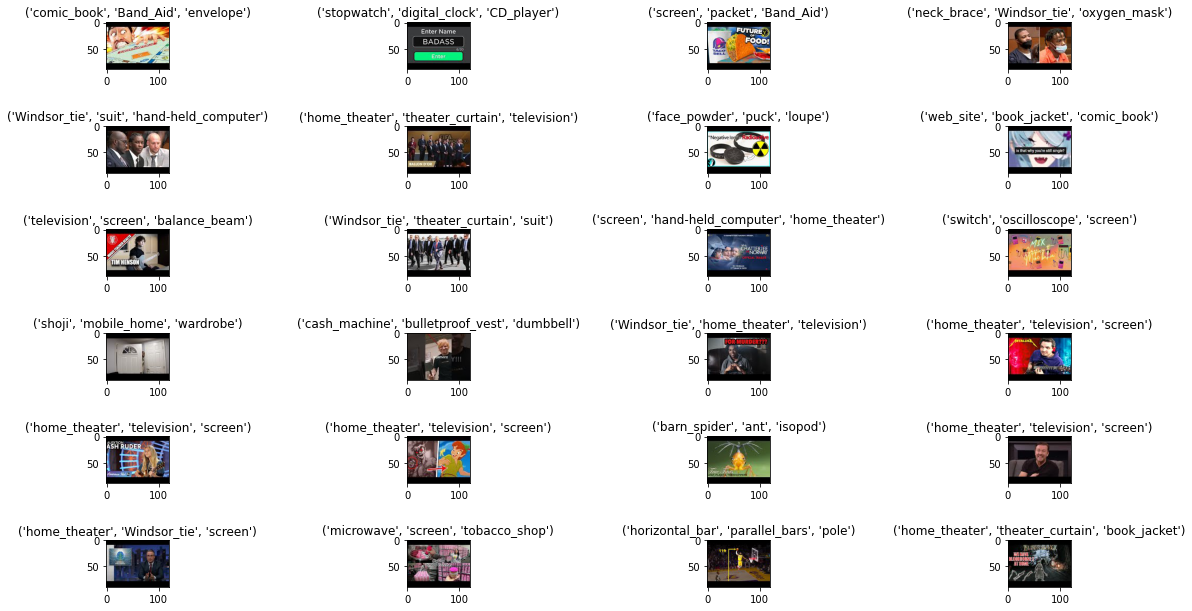

In [137]:
nrows, ncols = 6,4 #print first 16 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,8))
for i in range(nrows):
    for j in range(ncols):
        indx = i*ncols+j
        axs[i,j].imshow(images[0][indx])
        video_id = images[1][indx]
        axs[i,j].set(title=label_dict[video_id] )
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.2, wspace=0.4)